In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [2]:
emb_dim = 32
poll = 5
aedpmerf = AEDPMERF(is_priv=True)

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [3]:
model_name = f"poll{poll}_lstmae_180_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    aedpmerf.load_ae(model_name)
else:
    model, history = aedpmerf.train_ae()
    plt.plot(history["train"])
    plt.plot(history["val"])
    aedpmerf.save_ae(model_name)

loading AE model from models/poll5_lstmae_180_embed32.pth


In [4]:
eps = 0.5
lr = 9e-4
n_epochs = 2000
enc_df = aedpmerf.encode_train_data(train_ds_path=f"data/poll{poll}_normal_train_180.csv", fname=f"data/poll{poll}_normal_training_encoded_embed{emb_dim}_eps{eps}.csv")
aedpmerf.train_gen(data=enc_df, mini_batch_size=0.1, lr=lr, eps=eps, n_epochs=n_epochs)
n_gen_samples = enc_df.shape[0]
gen_data = aedpmerf.generate(n_gen_samples, fname=f"poll{poll}_enc_gen_priv_embed{emb_dim}_eps{eps}.csv")

saving encoded training data in data/poll5_normal_training_encoded_embed32_eps0.5.csv
minibatch:  6983
total number of datapoints in the training data is 69818
random freq (1000, 32)
adding DP noise
Starting Training
epoch # and running loss are  [0, 6.024554789066315]
epoch # and running loss are  [100, 0.003132442128844559]
epoch # and running loss are  [200, 0.0023617108090547845]
epoch # and running loss are  [300, 0.0022319712297758088]
epoch # and running loss are  [400, 0.002051985269645229]
epoch # and running loss are  [500, 0.0020621845760615543]
epoch # and running loss are  [600, 0.0020176661491859704]
epoch # and running loss are  [700, 0.0021240972710074857]
epoch # and running loss are  [800, 0.0017286172660533339]
epoch # and running loss are  [900, 0.0017603121814318001]
epoch # and running loss are  [1000, 0.0016044252115534618]
epoch # and running loss are  [1100, 0.0016420274041593075]
epoch # and running loss are  [1200, 0.0018093306571245193]
epoch # and running l

In [5]:
pd.DataFrame(gen_data).to_csv(f"data/generated/poll{poll}_normal_train_180_embed{emb_dim}_priv05_merf.csv")

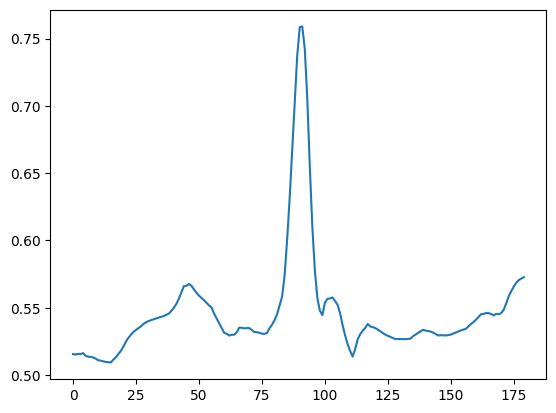

In [6]:
plt.plot(gen_data[345])

In [7]:
ae_gen = AutoEncTrainRoutine()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


loss: 99.175522  [    1/69828]
loss: 30.106544  [10001/69828]
loss: 2.712006  [20001/69828]
loss: 8.033009  [30001/69828]
loss: 1.650651  [40001/69828]
loss: 5.879423  [50001/69828]
loss: 7.425248  [60001/69828]
Epoch 1: train loss = 5.549781355330175, val loss = 5.510963833510566
loss: 7.751957  [    1/69828]
loss: 1.732290  [10001/69828]
loss: 1.441842  [20001/69828]
loss: 11.922732  [30001/69828]
loss: 0.937565  [40001/69828]
loss: 6.801033  [50001/69828]
loss: 1.717825  [60001/69828]
Epoch 2: train loss = 3.0130667782858582, val loss = 3.516644709973554
loss: 3.646682  [    1/69828]
loss: 0.927061  [10001/69828]
loss: 3.867236  [20001/69828]
loss: 1.454781  [30001/69828]
loss: 0.581125  [40001/69828]
loss: 2.264779  [50001/69828]
loss: 5.534288  [60001/69828]
Epoch 3: train loss = 2.3274186390510825, val loss = 3.200196038091402
loss: 1.954123  [    1/69828]
loss: 2.498528  [10001/69828]
loss: 1.422820  [20001/69828]
loss: 6.281689  [30001/69828]
loss: 0.738738  [40001/69828]
loss:

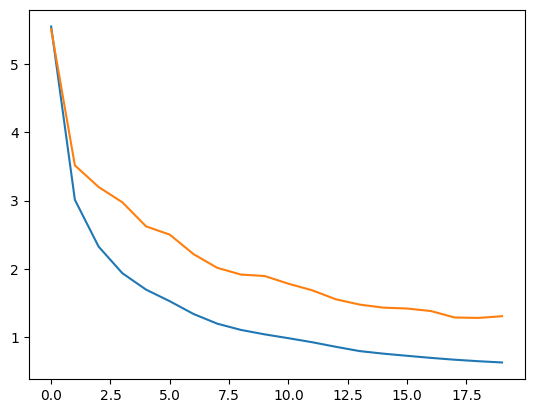

In [8]:
model_name = f"poll{poll}_dpmerf_priv05_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model(train_ds_path=f"data/generated/poll{poll}_normal_train_180_embed{emb_dim}_priv05_merf.csv", val_ds_path=f"data/poll{poll}_normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

In [9]:
pd.DataFrame(history["train"]).to_csv(f"loss_history/poll{poll}_priv05_merf_train.csv")
pd.DataFrame(history["val"]).to_csv(f"loss_history/poll{poll}_priv05_merf_val.csv")

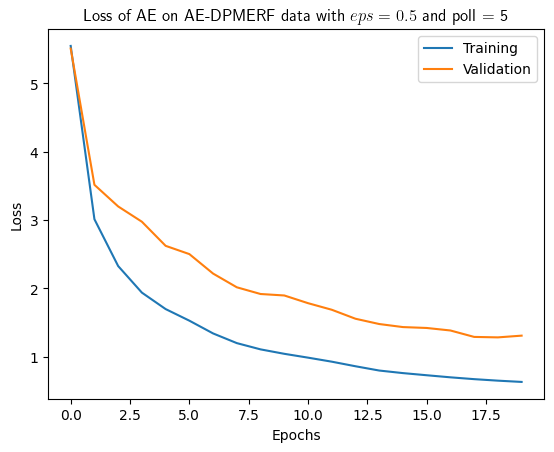

In [10]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title(f'Loss of AE on AE-DPMERF data with $ eps=0.5 $ and poll = {poll}', usetex=True)
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
window_size=180
evaluator = Evaluator(val_normal_path=f"data/poll{poll}_normal_val_{window_size}.csv",
                      val_anomaly_path=f"data/poll{poll}_anomalie_val_{window_size}.csv",
                        test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


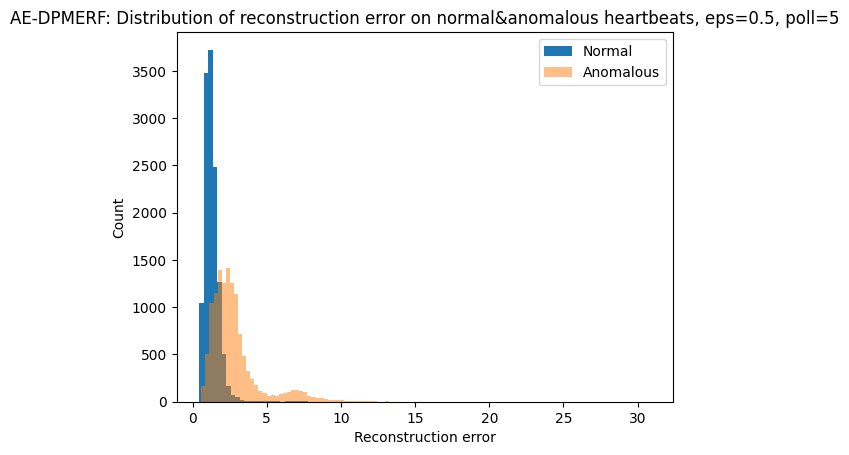

In [12]:
plt.figure()

plt.hist(evaluator.loss_val_normal, bins=100)

plt.title(f"AE-DPMERF: Distribution of reconstruction error on normal&anomalous heartbeats, eps={eps}, poll={poll}")

plt.hist(evaluator.loss_val_anomaly, bins=100, alpha=0.5)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")

plt.legend(["Normal", "Anomalous"])

plt.show()

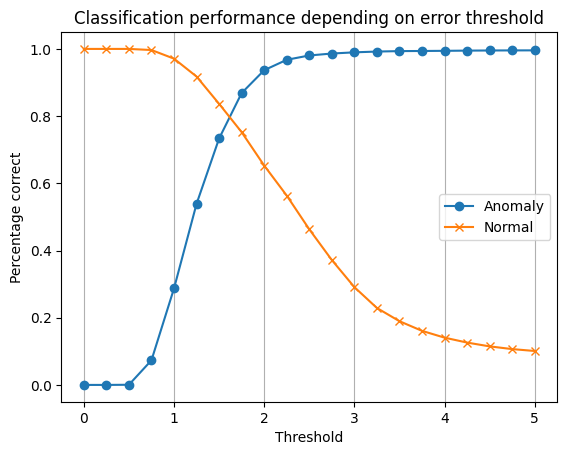

In [14]:
corr_normal, corr_anomaly = evaluator.find_threshold()
plt.plot(np.linspace(0,5,21), corr_normal, marker="o")
plt.plot(np.linspace(0,5,21), corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.grid(axis="x")
plt.title("Classification performance depending on error threshold")
plt.show()

In [15]:
predictions_normal, predictions_anomaly = evaluator.predict_class(1.625)


In [16]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 1444
FN: 316
FP: 359
TN: 1445
Acc: 0.8106060606060606
Precision: 0.8008874098724348
Recall: 0.8204545454545454
F1: 0.8105529048554588
